In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [83]:
# Save as Dataframe the train file and keep only Store, Dept, Sales and use Date as Index
train_file = 'data/train.csv'

train_df = pd.read_csv(train_file)
train_df['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in train_df['Date'].astype(str).values.tolist()]
train_df.index = train_df['Date']
train_df = train_df.drop(['Date', 'IsHoliday'], axis=1)

print(train_df.head())

            Store  Dept  Weekly_Sales
Date                                 
2010-02-05      1     1      24924.50
2010-02-12      1     1      46039.49
2010-02-19      1     1      41595.55
2010-02-26      1     1      19403.54
2010-03-05      1     1      21827.90


In [184]:
# Define a function to plot sales evolution depending of the store and department number
def sales_evolution(store_number, dept_number):
    example_store_dept_sales = train_df[(train_df.Store == store_number) & (train_df.Dept == dept_number)]['Weekly_Sales']
    plt.figure(figsize=(8,3))
    example_store_dept_sales.plot(title='Store {} Dpt {} Sales evolution'.format(store_number, dept_number), color='blue') 
    return plt.show()

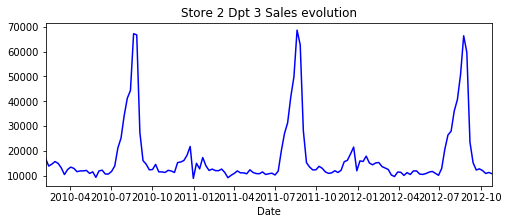

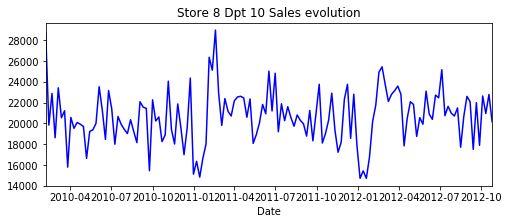

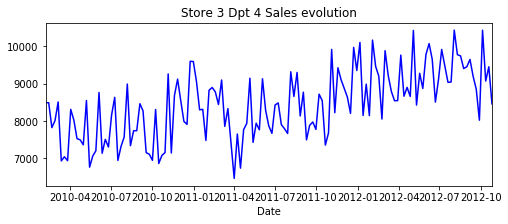

In [185]:
# Plot some examples
sales_evolution(2,3)
sales_evolution(8,10)
sales_evolution(3,4)

In [201]:
def make_time_series(df, years, freq='W-FRI'):
    '''Creates as many time series as they are stores x departments x complete years. 
      :param df: dataframe with train data. One 3 columns : Store, Dept, Weekly_Sales.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    train_time_series = []
    
    # create time series for each store and each department
    for store in df.Store.unique().tolist():
        for dept in df.Dept.unique().tolist():
            
            # create DataFrame with weekly_sales for the store and department studied
            sample_df = df[(df.Store == store) & (df.Dept == dept)]['Weekly_Sales']
                        
            # initialise start_idx
            start_idx = 0
            
            # create time series for each year in years
            for i in range(len(years)):

                # for each year 52 weeks (no year of 53 weeks in our dataset)
                year = years[i]
                end_idx = start_idx+52

                # create start and end datetimes
                t_start = year + '-02-05' # start with first date 
                t_end = str(int(year)+1) + '-01-28' # end friday one year later

                # get wanted sample_df data
                data = sample_df[start_idx:end_idx]

                # create time series for the year
                index = pd.date_range(start=t_start, end=t_end, freq=freq)
                Serie_df = pd.Series(data=data, index=index)
                
                # include info of the store and dept as last values to use as category in DeepAR
                Info_df = pd.Series(data=[int(store), int(dept)], index=['store','dept'])
                train_time_series.append(pd.concat([Serie_df, Info_df]))
                
                # start next year in loop
                start_idx = end_idx+1                
    
    # return list of time series
    return train_time_series

In [202]:
# Create yearly time series for our 2 complete years
full_years = ['2010', '2011']
freq='W-FRI' # weekly recordings

# make time series
train_time_series = make_time_series(train_df, full_years, freq=freq)

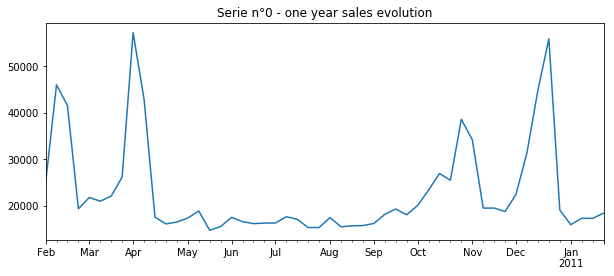

In [215]:
# display first time series
time_series_idx = 0

# plot time series except the last two values corresponding to store and department
plt.figure(figsize=(10,4))
train_time_series[time_series_idx][:-2].plot(title='Serie n°{} - one year sales evolution'.format(time_series_idx))
plt.show()

In [216]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target and cat from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts[:-2]), "cat": list(map(int, ts[-2:]))}
    return json_obj

In [217]:
# test out the code
ts = train_time_series[1]

json_obj = series_to_json_obj(ts)

print(json_obj)

{'start': '2011-02-11 00:00:00', 'target': [37887.17, 46845.87, 19363.83, 20327.61, 21280.4, 20334.23, 20881.1, 20398.09, 23873.79, 28762.37, 50510.31, 41512.39, 20138.19, 17235.15, 15136.78, 15741.6, 16434.15, 15883.52, 14978.09, 15682.81, 15363.5, 16148.87, 15654.85, 15766.6, 15922.41, 15295.55, 14539.79, 14689.24, 14537.37, 15277.27, 17746.68, 18535.48, 17859.3, 18337.68, 20797.58, 23077.55, 23351.8, 31579.9, 39886.06, 18689.54, 19050.66, 20911.25, 25293.49, 33305.92, 45773.03, 46788.75, 23350.88, 16567.69, 16894.4, 18365.1, 18378.16], 'cat': [1, 1]}
